# Background removal with U-net on Inferentia2 + SageMaker

**SageMaker Studio Kernel**: Python 3 (PyTorch 1.13 Python 3.9 CPU Optimized)  
**Instance**: ml.t3.medium

In this notebook, you'll use a public implementation of u-net, pretrained to identify & remove background: https://github.com/Saeed-Biabani/Background-Removal.git . You'll download the weights, compile to Inferentia 2 and deploy to a SageMaker endpoint powered by Inf2.


In [ ]:
%pip install -U sagemaker
%pip install matplotlib

In [ ]:
import os
import boto3
import sagemaker

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()

bucket = sess.default_bucket()
region = sess.boto_region_name

os.makedirs("src", exist_ok=True)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {bucket}")
print(f"sagemaker session region: {region}")

## 2) Download model weights and upload to S3

In [ ]:
import urllib.request
url_model_weights="https://huggingface.co/ordaktaktak/Background-Removal/resolve/main/bgrm-bh.pth?download=true"
s3_key='models/bgrm/model.pth'
with urllib.request.urlopen(url_model_weights) as f:
    s3_uri = sess.upload_string_as_file_body(f.read(), bucket=bucket, key=s3_key)
    print(s3_uri)

## 3) Clone the u-net implementation and patch it

In [ ]:
%%writefile p.patch
diff --git a/HumanSegmentation.py b/HumanSegmentation.py
index a183733..b4d16ff 100644
--- a/HumanSegmentation.py
+++ b/HumanSegmentation.py
@@ -13,7 +13,7 @@ class BodyDetector(nn.Module):
         self.__load_model__(model_path)
 
     def __load_model__(self, fname):
-        self.model.load_state_dict(torch.load(fname))
+        self.model.load_state_dict(torch.load(fname, map_location=self.device))
         self.model.eval()
 
 


In [ ]:
!git clone https://github.com/Saeed-Biabani/Background-Removal.git src/ && cd src && git checkout d590d3b && git apply < ../p.patch

## 4) Create the compilation scripts and Kick-off the compilation step

In [ ]:
%%writefile src/requirements.txt
einops

In [ ]:
%%writefile src/compile.py
import os
os.environ['NEURON_RT_NUM_CORES']='1'
os.environ['NEURON_CC_FLAGS']="--model-type=unet --cache_dir=./cache"
import io
import cv2
import torch
import argparse
import torch.nn
import numpy as np
import torch_neuronx

def model_fn(model_dir, context=None):
    return torch.jit.load(os.path.join(model_dir, "model.pt"))

def input_fn(request_body, request_content_type, context=None):
    if request_content_type == "image/jpeg":
        img = cv2.imdecode(np.frombuffer(request_body, dtype=np.uint8), cv2.IMREAD_COLOR)
        h,w,c = img.shape
        if w!=h: # make it square to avoid distortions
            max_size = max(h,w)
            img_new = np.zeros(max_size,max_size,c).astype(np.uint8)
            img_new[:h,:w],img = img[:],img_new
        img = cv2.resize(img, (224,224))
        img = (img.transpose(2,0,1) / 255.0).astype(np.float32) # HWC -> CHW / to FP32
        img = ((img - img.mean()) / img.std()) # normalize
        img = np.expand_dims(img, axis=0) # make a batch size = 1
        img = torch.from_numpy(img) # transform to tensor
        return img,w,h
    else:
        raise Exception(f"Unsupported mime type: {request_content_type}. Supported: application/json")

def predict_fn(input_req, model, context=None):
    x,w,h = input_req
    pred = model(x)
    pred = torch.nn.Sigmoid()(pred)

    mask = pred.numpy()[0]    
    mask = np.moveaxis(mask, 0, -1)
    mask = mask[:h, :w] # remove the additional pixels
    return np.where(mask > (mask.mean() + abs(mask.std() / 2)), 0, 255).astype("uint8")

def output_fn(image, accept, context=None):
    if accept!='image/png':
        raise Exception(f'Invalid data type. Expected image/jpeg, got {accept}')

    out = io.BytesIO(cv2.imencode(".png", image)[1])
    return out.read()

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--weights_dir", type=str, default=os.environ.get("SM_CHANNEL_WEIGHTS", None))

    args, _ = parser.parse_known_args()
    
    from HumanSegmentation import BodyDetector    
    print("Loading model...")
    model = BodyDetector(os.path.join(args.weights_dir, 'model.pth')).model
    x = torch.rand(1,3,224,224)
    print("Warming up model...")
    y = model(x)
    print("Tracing model...")
    neuron_model = torch_neuronx.trace(model, x)
    print("Saving model...")
    torch.jit.save(neuron_model, os.path.join(args.model_dir, "model.pt"))
    
    code_path = os.path.join(args.model_dir, "code")
    os.makedirs(code_path, exist_ok=True)
    shutil.copy("compile.py", os.path.join(code_path, "inference.py"))
    shutil.copy("requirements.txt", os.path.join(code_path, "requirements.txt"))
    print(f"Job done!")
    os._exit(0)

In [ ]:
import json
import logging
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="compile.py", # Specify your train script
    source_dir="src",
    role=role,
    sagemaker_session=sess,    
    instance_count=1,
    instance_type='ml.trn1.2xlarge', # a big instance is required for compilation
    output_path=f"s3://{bucket}/output",
    disable_profiler=True,
    disable_output_compression=True,

    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training-neuronx:2.1.1-neuronx-py310-sdk2.17.0-ubuntu20.04",
    
    volume_size = 128,
)
estimator.framework_version = '1.13.1' # workround when using image_uri

In [ ]:
estimator.fit({'weights': s3_uri})
model_data = estimator.model_data
print(model_data)

## 5) Deploy the model to inf2

In [ ]:
import logging
from sagemaker.utils import name_from_base
from sagemaker.pytorch.model import PyTorchModel

instance_type_idx=0
instance_types=['ml.inf2.xlarge','ml.inf2.8xlarge', 'ml.inf2.24xlarge','ml.inf2.48xlarge']
num_cores=[2,2,12,24]
num_workers=num_cores[instance_type_idx]

print(f"Instance type: {instance_types[instance_type_idx]}. Num SM workers: {num_workers}")
pytorch_model = PyTorchModel(
    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-inference-neuronx:2.1.1-neuronx-py310-sdk2.17.0-ubuntu20.04",
    model_data=model_data,
    role=role,    
    name=name_from_base('unet-bgrm'),
    sagemaker_session=sess,
    container_log_level=logging.DEBUG,
    model_server_workers=num_workers,
    framework_version="2.1.1",
    env = {
        'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600',
    },
    # for production it is important to define vpc_config and use a vpc_endpoint
    #vpc_config={
    #    'Subnets': ['<SUBNET1>', '<SUBNET2>'],
    #    'SecurityGroupIds': ['<SECURITYGROUP1>', '<DEFAULTSECURITYGROUP>']
    #}
)
pytorch_model._is_compiled_model = True

In [ ]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=instance_types[instance_type_idx],
    model_data_download_timeout=600, # it takes some time to download all the artifacts and load the model
    container_startup_health_check_timeout=600
)

## 6) run a simple test

In [ ]:
import cv2
import numpy as np
from sagemaker.serializers import DataSerializer
from sagemaker.deserializers import BytesDeserializer

predictor.serializer = DataSerializer(content_type='image/jpeg')
predictor.deserializer = BytesDeserializer(accept='image/png')

In [ ]:
mask = predictor.predict(open('woman.jpg', 'rb').read())
img = np.frombuffer(mask, dtype=np.uint8)
img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (896,896))
cv2.imwrite('woman_mask.png', img)

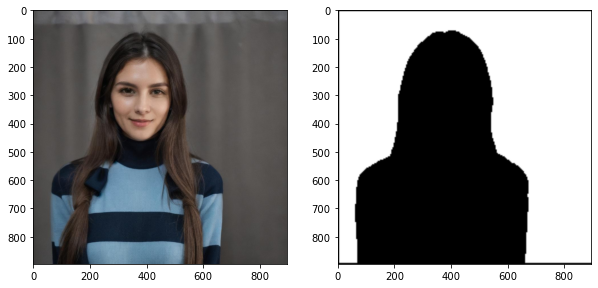

In [153]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
rows,cols=1,2
fig.add_subplot(rows, cols, 1)
plt.imshow(cv2.cvtColor(cv2.imread('woman.jpg'), cv2.COLOR_BGR2RGB))
fig.add_subplot(rows, cols, 2)
plt.imshow(cv2.cvtColor(cv2.imread('woman_mask.png'), cv2.COLOR_BGR2RGB))
plt.show()

## 7) Cleanup

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()